## Bitcoin Price and Volume Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

import requests

from scipy import stats

In [2]:
# Download BTC Hourly Prices Using CryptoCompare API
r = requests.get("https://min-api.cryptocompare.com/data/v2/histohour?fsym=BTC&tsym=USD&limit=2000")
prices = pd.DataFrame(r.json()['Data']['Data'])[['time', 'high', 'low', 'open', 'close', 'volumeto']]
prices.index = pd.to_datetime(prices.time, unit='s')
prices = prices.drop('time', axis=1)
# Use this code below to save the csv file for later
#prices.to_csv("btc_hourly_prices.csv")

prices.volumeto = prices.volumeto / 1_000_000
prices = prices.dropna()

### Analysis of Volatility and Price Returns

We will use Parkinson's Historical Volatility with a 3 hour rolling window. 

In [3]:
def park_vol(data, window=3, period=3):
    # 24 hour period represents daily volatility and rolling window period
    z = (1/(4*np.log(2))*(np.log(data.high/data.low))**2)
    return (z.rolling(window=window).mean()**0.50)*period

In [4]:
prices['park_vol'] = park_vol(prices)
prices = prices.dropna()

In [5]:
def regression(data, dependent, independent, subset=False):
    # Helper function used to plot regression line ontop of scattered data
    
    regr = linear_model.LinearRegression()
    x = data[independent].values.reshape(-1,1)
    y = data[dependent].values.reshape(-1,1)
    regr.fit(x, y)
    pred = regr.predict(x)
    
    f, ax = plt.subplots(figsize=(7, 5))

    ax.scatter(x, y, alpha=0.50)
    ax.plot(x, pred, c='r')
    plt.xlabel(str(independent))
    plt.ylabel(str(dependent))
    plt.annotate('R-Squared = %.3f' % r2_score(y, pred), (0.8, 0.7), 
             xycoords='axes fraction', ha='center', va='center', size=10)
    
    title = independent.capitalize() + ' vs ' + dependent.capitalize()
    plt.title(title)
    return ax

In [6]:
# Generate additional features

# calculate mid-price
prices['mid'] = (prices.high + prices.low)/2
prices['mid_pct'] = prices.mid.pct_change()

# current high value / current low value
prices['high_low_ratio'] = prices.high/prices.low

# current close value / previous high value
prices['close_high_ratio'] = prices.close/prices.high.shift(1)

prices = prices.dropna()

### Seaborn Pairplot to Identify Interesting Relationships

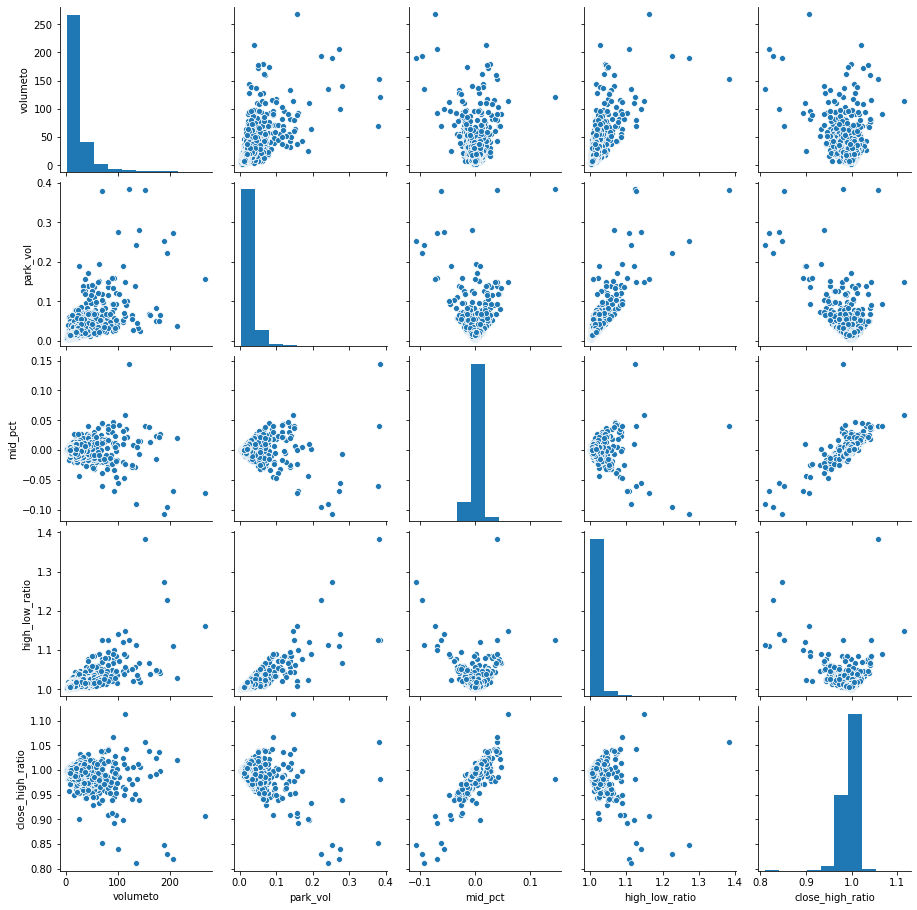

In [7]:
sns.pairplot(prices[['volumeto', 'park_vol', 'mid_pct', 'high_low_ratio', 'close_high_ratio']])

#### Volume vs. Volatility

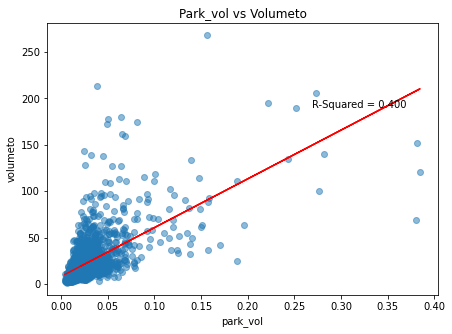

In [8]:
# Higher volatility in the market is associated with higher volumes 
regression(prices, "volumeto", "park_vol");

#### Percentage Change vs. Volatility

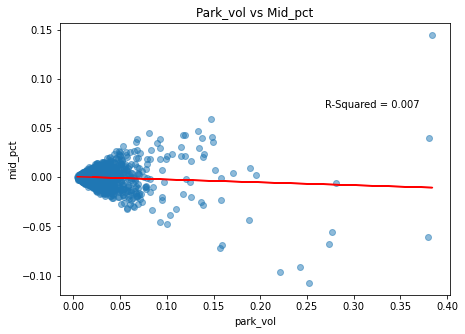

In [9]:
# Hard to determine if there is any relationship here. This data appears to be better suited for a non-linear regression
regression(prices, "mid_pct", "park_vol");

#### Volatility vs. High/Low Ratio

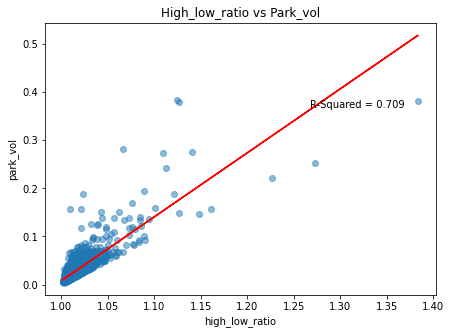

In [10]:
# This makes sense because a higher ratio indicates a larger spread, hence higher volatility
regression(prices, "park_vol", "high_low_ratio");

#### Volatility vs. Close/High Ratio

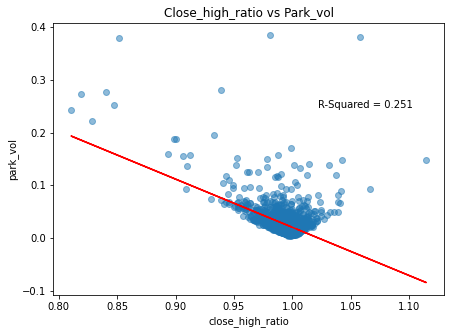

In [11]:
# It seems that linear regression is not the best model for this case. Here we took the ratio of the current close 
# divided by the previous high price. 
regression(prices, "park_vol", "close_high_ratio");

#### Quick Statistical Analysis of Mid-Point Returns

In [12]:
print("skew:", stats.skew(prices.mid_pct))
print("kurtosis:", stats.kurtosis(prices.mid_pct))

# Heavy tails and skewed to the left-hand based on this sample of ~ 80 days of hourly returns
# I expect this analysis to be different if we instead use daily based data

skew: -0.3205357345595948
kurtosis: 41.81297786532966


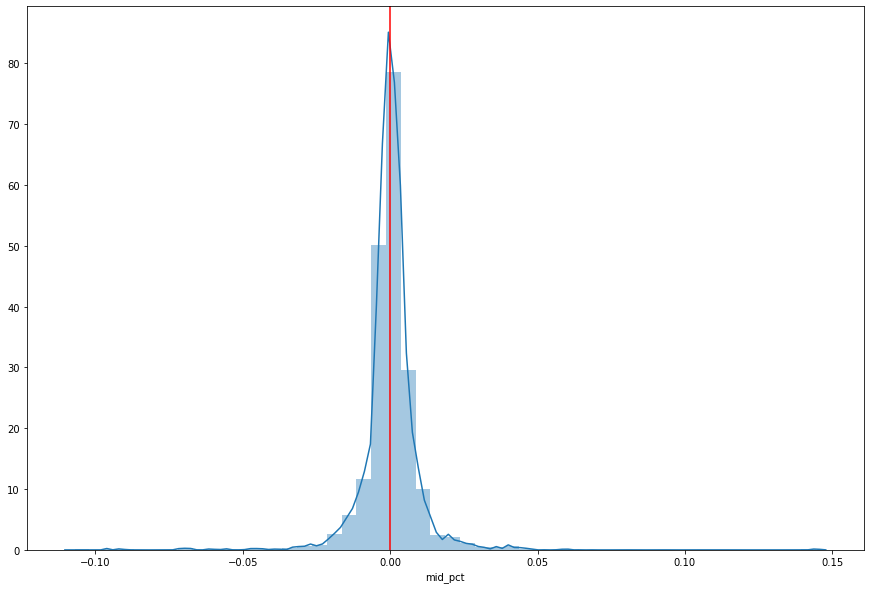

In [13]:
plt.figure(figsize=(15,10))
sns.distplot(prices.mid_pct, hist=True)
plt.axvline(0, c='r')

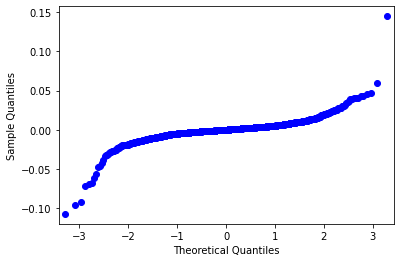

In [14]:
# The tails at the end are very extreme - just another reason to be careful with large leveraged positions!
sm.qqplot(prices.mid_pct);